# CNNs to Decode ECoG Data
Run the first few cells to normalize Local / Colab environments, then proceed below.

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.cwd() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if not (Path.cwd() / 'repo').is_dir():
        # Download the workshop repo and change to its directory
        # For now edit the username/password. This requirement will be removed when the repo is made public.
        !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
    import tensorflow as tf
    # Setup tensorboard callback
    !pip install tensorboardcolab
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    tbc=TensorBoardColab(startup_waiting_time=30)
    tensorboard_callback = TensorBoardColabCallback(tbc)
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    # Clear any logs from previous runs
    if (Path.cwd() / 'logs').is_dir():
        import platform
        if platform.system() == 'Windows':
            !rmdir /S /Q logs
        else:
            !rm -Rf logs
    # Setup tensorboard callback
    import tensorflow as tf
    import datetime
    %load_ext tensorboard.notebook
    log_dir = Path.cwd() / "logs" / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()
    print("Finished extracting data.")

## Prepare data from one participant
See 02_02 for an explanation.
However, this time we are loading the full-band data time-domain data
at the original sampling rate.
### Load

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from data.utils.fileio import from_neuropype_h5

# define a helper function to load the data
def load_faces_houses(sub_id):
    test_file = datadir / 'converted' / 'faces_basic' / (sub_id + '_full.h5')
    chunks = from_neuropype_h5(test_file)
    chunk_names = [_[0] for _ in chunks]
    chunk = chunks[chunk_names.index('signals')][1]
    ax_types = [_['type'] for _ in chunk['axes']]
    instance_axis = chunk['axes'][ax_types.index('instance')]
    n_trials = len(instance_axis['data'])
    X = chunk['data']
    Y = instance_axis['data']['Marker'].values.reshape(-1, 1)
    ax_info = {'instance_data': instance_axis['data'],
               'fs': chunk['axes'][ax_types.index('time')]['nominal_rate'],
               'timestamps': chunk['axes'][ax_types.index('time')]['times'],
               'channel_names': chunk['axes'][ax_types.index('space')]['names']
              }
    return X, Y, ax_info

# Load data from one participant.
SUB_ID = 'mv'
X, Y, ax_info = load_faces_houses(SUB_ID)
n_trials = X.shape[0]

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))
# print(ax_info['channel_names'])

Found 603 trials, 801 timestamps (-0.2 to 0.6 at 1000 Hz), 58 channels


### Get baseline accuracy
Remember, the signals haven't been processed much. The only features we can expect LDA to pick out are stimulus-evoked time-domain signals. Also with 801 * 58 features, over-fitting is likely. Unfortunately, the LDA 'eigen' solver can't handle this ~600 x ~4800 matrix so we can't use its shrinkage. So we'll try regularized logistic regression instead. (Though it has 'regression' in the name, it's actually a classification algorithm).

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 200
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=10)

y_preds = []
y_true = []
for trn, tst in splitter.split(X, Y):
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("3-class accuracy: {}".format(pcnt_corr))

3-class accuracy: 92.20563847429518


So even with way more features and without signal processing, we're getting fairly high accuracy at 92%. Our goal is for the deep model to do at least as well and to hopefully provide some insight along the way.

### Prepare data for deep learning
See 02_02 notebook for explanation.

In [5]:
def get_ds_train_valid(X, Y, p_train=0.8, batch_size=5):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_classes = len(classes)
    n_trials = len(y)
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        y_dat = tf.one_hot(tf.cast(y_dat, tf.uint8), n_classes)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=p_train)
    n_train = len(y_train)
    n_valid = len(y_valid)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    ds_train = ds_train.shuffle(int(n_trials * p_train) + 1).batch(batch_size, drop_remainder=True).repeat()  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size).repeat()
    
    return ds_train, ds_valid, n_train
    
PTRAIN = 0.8
BATCH_SIZE = 5
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=BATCH_SIZE)

# TODO: proper cross-validation

## Create our model
As in 02_02, our objective is to decode the stimulus class ('ISI', 'face', or 'house')
from the ECoG data.
Let's start off with a model that someone else developed for similar purposes.

* [One for EEG](https://iopscience.iop.org/article/10.1088/1741-2552/aaf3f6)
* [ECoG CNNs with LSTMs](https://iopscience.iop.org/article/10.1088/1741-2552/aa9dbe/meta)
    1. CNN for spatial unmixing matrix [77] initialized with fast ICA
    1. 3 temporal CNN layers, with [2, 4, 8] filters of kernel size 1 x 17 per layer,
    initialized with biorthogonal wavelet 6.8.
* [ECoG CNNs with autoencoders](https://iopscience.iop.org/article/10.1088/1741-2552/aaf13f/pdf)


In [6]:
# Create a convenience function for adding a multilayer block
def cnn_block(inputs, n_filters=16, filter_length=8, activation='relu', pool_size=1, strides=None, dropout_rate=0.0):
    y_ = inputs
    y_ = tf.keras.layers.BatchNormalization()(y_)
    y_ = tf.keras.layers.Conv1D(n_filters, filter_length, activation=activation)(y_)
    if pool_size > 1:
        y_ = tf.keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides)(y_)
    if dropout_rate > 0.0:
        y_ = tf.keras.layers.Dropout(rate=dropout_rate)(y_)
    return y_


N_FILTERS = [64, 64, 32, 16, 8]
FILTER_LENGTHS = [12, 12, 8, 3, 3]

inputs = tf.keras.layers.Input(shape=X.shape[1:])
y_ = tf.keras.layers.Dense(64, activation='linear')(inputs)  # spat filt
# y_ = tf.keras.layers.Conv1D(64, 1)(inputs)  # spat filt.
for n_filts, filt_length in zip(N_FILTERS, FILTER_LENGTHS):
    y_ = cnn_block(y_, n_filters=n_filts, filter_length=filt_length, pool_size=3, dropout_rate=0.2)
y_ = tf.keras.layers.Flatten()(y_)
outputs = tf.keras.layers.Dense(3, activation='softmax')(y_)
model = tf.keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Wsave = model.get_weights()  # Save the weights for later

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 801, 58)]         0         
_________________________________________________________________
dense (Dense)                (None, 801, 64)           3776      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 801, 64)           256       
_________________________________________________________________
conv1d (Conv1D)              (None, 790, 64)           49216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 263, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 263, 64)           0         
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 263, 64)           256   

In [7]:
N_EPOCHS = 20
history = model.fit(x=ds_train,  
                    epochs=N_EPOCHS, 
                    validation_data=ds_valid,
                    steps_per_epoch=n_train // BATCH_SIZE,
                    validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                    verbose=1)

Epoch 1/20
 1/96 [..............................] - ETA: 12:23 - loss: 0.7930 - accuracy: 0.6000

W0526 00:47:45.588757  6044 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.231905). Check your callbacks.


 2/96 [..............................] - ETA: 6:22 - loss: 1.6342 - accuracy: 0.5000 

W0526 00:47:45.612051  6044 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.187480). Check your callbacks.


96/96 [==============================] - ETA: 2:28 - loss: 1.3963 - accuracy: 0.52 - ETA: 1:10 - loss: 1.3199 - accuracy: 0.42 - ETA: 48s - loss: 1.4504 - accuracy: 0.3714 - ETA: 36s - loss: 1.3882 - accuracy: 0.411 - ETA: 28s - loss: 1.3562 - accuracy: 0.436 - ETA: 22s - loss: 1.3281 - accuracy: 0.453 - ETA: 17s - loss: 1.2637 - accuracy: 0.483 - ETA: 14s - loss: 1.2648 - accuracy: 0.468 - ETA: 12s - loss: 1.2471 - accuracy: 0.471 - ETA: 10s - loss: 1.2382 - accuracy: 0.469 - ETA: 8s - loss: 1.2248 - accuracy: 0.475 - ETA: 7s - loss: 1.2249 - accuracy: 0.46 - ETA: 6s - loss: 1.2263 - accuracy: 0.47 - ETA: 5s - loss: 1.1793 - accuracy: 0.49 - ETA: 4s - loss: 1.1706 - accuracy: 0.49 - ETA: 3s - loss: 1.1465 - accuracy: 0.50 - ETA: 2s - loss: 1.1457 - accuracy: 0.50 - ETA: 2s - loss: 1.1278 - accuracy: 0.51 - ETA: 1s - loss: 1.1386 - accuracy: 0.50 - ETA: 1s - loss: 1.1389 - accuracy: 0.50 - ETA: 0s - loss: 1.1432 - accuracy: 0.50 - ETA: 0s - loss: 1.1223 - accuracy: 0.50 - 10s 107ms/ste

96/96 [==============================] - ETA: 8s - loss: 0.8583 - accuracy: 0.40 - ETA: 2s - loss: 0.5562 - accuracy: 0.68 - ETA: 1s - loss: 0.5438 - accuracy: 0.71 - ETA: 1s - loss: 0.6422 - accuracy: 0.67 - ETA: 1s - loss: 0.6092 - accuracy: 0.68 - ETA: 1s - loss: 0.5852 - accuracy: 0.69 - ETA: 1s - loss: 0.6305 - accuracy: 0.69 - ETA: 1s - loss: 0.6310 - accuracy: 0.69 - ETA: 0s - loss: 0.6256 - accuracy: 0.69 - ETA: 0s - loss: 0.6080 - accuracy: 0.69 - ETA: 0s - loss: 0.6281 - accuracy: 0.68 - ETA: 0s - loss: 0.6242 - accuracy: 0.68 - ETA: 0s - loss: 0.6072 - accuracy: 0.69 - ETA: 0s - loss: 0.5939 - accuracy: 0.71 - ETA: 0s - loss: 0.5973 - accuracy: 0.71 - ETA: 0s - loss: 0.6016 - accuracy: 0.70 - ETA: 0s - loss: 0.6074 - accuracy: 0.70 - ETA: 0s - loss: 0.5917 - accuracy: 0.71 - ETA: 0s - loss: 0.5855 - accuracy: 0.71 - ETA: 0s - loss: 0.5775 - accuracy: 0.71 - ETA: 0s - loss: 0.5718 - accuracy: 0.71 - ETA: 0s - loss: 0.5782 - accuracy: 0.71 - ETA: 0s - loss: 0.5811 - accuracy: 

96/96 [==============================] - ETA: 9s - loss: 0.1253 - accuracy: 1.00 - ETA: 2s - loss: 0.3138 - accuracy: 0.92 - ETA: 1s - loss: 0.3268 - accuracy: 0.86 - ETA: 1s - loss: 0.2709 - accuracy: 0.89 - ETA: 1s - loss: 0.2598 - accuracy: 0.89 - ETA: 1s - loss: 0.2460 - accuracy: 0.91 - ETA: 1s - loss: 0.2497 - accuracy: 0.91 - ETA: 1s - loss: 0.2616 - accuracy: 0.90 - ETA: 0s - loss: 0.2615 - accuracy: 0.90 - ETA: 0s - loss: 0.2781 - accuracy: 0.90 - ETA: 0s - loss: 0.2818 - accuracy: 0.89 - ETA: 0s - loss: 0.2786 - accuracy: 0.90 - ETA: 0s - loss: 0.2742 - accuracy: 0.90 - ETA: 0s - loss: 0.2750 - accuracy: 0.89 - ETA: 0s - loss: 0.2740 - accuracy: 0.89 - ETA: 0s - loss: 0.2795 - accuracy: 0.88 - ETA: 0s - loss: 0.2722 - accuracy: 0.89 - ETA: 0s - loss: 0.2744 - accuracy: 0.88 - ETA: 0s - loss: 0.2860 - accuracy: 0.87 - ETA: 0s - loss: 0.2913 - accuracy: 0.87 - ETA: 0s - loss: 0.2913 - accuracy: 0.87 - ETA: 0s - loss: 0.2868 - accuracy: 0.87 - ETA: 0s - loss: 0.2846 - accuracy: 

In [8]:
if False and not IN_COLAB:
    tb_dir = 'logs/' + str(log_dir.stem)
    print(tb_dir)
    %tensorboard --logdir={tb_dir}

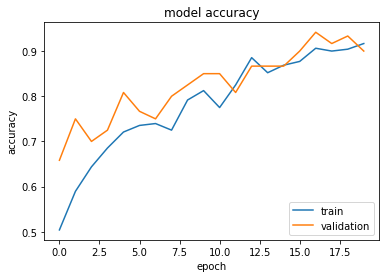

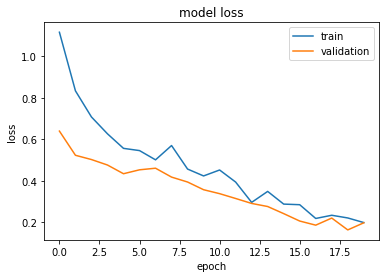

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

93% isn't much better than what we got with logistic regression,
but let's see what we can learn from the model.

TODO
* Inspect spatial filter
* Inspect maximum activations

## Transfer Learning
* Freeze layers, update only first layer, then unfreeze and update

In [11]:
#Reset the model weights to before training
model.set_weights(Wsave)

def replace_input_layers(old_model, new_input_shape):
    inputs = tf.keras.layers.Input(shape=new_input_shape)
    _y = tf.keras.layers.Dense(64, activation='linear')(inputs)  # spat filt
    for layer_ix, layer in enumerate(old_model.layers):
        if layer_ix > 1:
            _y = layer(_y)
    return tf.keras.Model(inputs, _y)

# Choose another participant, replace the input layers to match new input size, and retrain the model.
X, Y, ax_info = load_faces_houses('de')
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=BATCH_SIZE)
xfer_model = replace_input_layers(model, X.shape[1:])
xfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
xfer_model.summary()

N_EPOCHS = 20
history = xfer_model.fit(x=ds_train,  
                     epochs=N_EPOCHS, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 801, 31)]         0         
_________________________________________________________________
dense_2 (Dense)              (None, 801, 64)           2048      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 801, 64)           256       
_________________________________________________________________
conv1d (Conv1D)              (None, 790, 64)           49216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 263, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 263, 64)           0         
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 263, 64)           256 

96/96 [==============================] - ETA: 4s - loss: 0.7692 - accuracy: 0.40 - ETA: 1s - loss: 0.3842 - accuracy: 0.88 - ETA: 1s - loss: 0.3997 - accuracy: 0.88 - ETA: 1s - loss: 0.4582 - accuracy: 0.81 - ETA: 1s - loss: 0.4489 - accuracy: 0.78 - ETA: 1s - loss: 0.4261 - accuracy: 0.80 - ETA: 0s - loss: 0.4413 - accuracy: 0.80 - ETA: 0s - loss: 0.4446 - accuracy: 0.81 - ETA: 0s - loss: 0.4453 - accuracy: 0.81 - ETA: 0s - loss: 0.4372 - accuracy: 0.81 - ETA: 0s - loss: 0.4290 - accuracy: 0.81 - ETA: 0s - loss: 0.4189 - accuracy: 0.81 - ETA: 0s - loss: 0.4203 - accuracy: 0.81 - ETA: 0s - loss: 0.4100 - accuracy: 0.81 - ETA: 0s - loss: 0.4227 - accuracy: 0.81 - ETA: 0s - loss: 0.4212 - accuracy: 0.80 - ETA: 0s - loss: 0.4209 - accuracy: 0.80 - ETA: 0s - loss: 0.4107 - accuracy: 0.81 - ETA: 0s - loss: 0.4133 - accuracy: 0.81 - ETA: 0s - loss: 0.4294 - accuracy: 0.80 - ETA: 0s - loss: 0.4418 - accuracy: 0.79 - ETA: 0s - loss: 0.4395 - accuracy: 0.79 - ETA: 0s - loss: 0.4360 - accuracy: 

96/96 [==============================] - ETA: 4s - loss: 0.0209 - accuracy: 1.00 - ETA: 1s - loss: 0.0916 - accuracy: 0.96 - ETA: 1s - loss: 0.2244 - accuracy: 0.86 - ETA: 1s - loss: 0.2395 - accuracy: 0.87 - ETA: 1s - loss: 0.2298 - accuracy: 0.88 - ETA: 1s - loss: 0.2334 - accuracy: 0.88 - ETA: 1s - loss: 0.2324 - accuracy: 0.89 - ETA: 0s - loss: 0.2227 - accuracy: 0.90 - ETA: 0s - loss: 0.2293 - accuracy: 0.90 - ETA: 0s - loss: 0.2390 - accuracy: 0.90 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.89 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - ETA: 0s - loss: 0.2316 - accuracy: 0.89 - ETA: 0s - loss: 0.2219 - accuracy: 0.90 - ETA: 0s - loss: 0.2342 - accuracy: 0.89 - ETA: 0s - loss: 0.2315 - accuracy: 0.89 - ETA: 0s - loss: 0.2357 - accuracy: 0.89 - ETA: 0s - loss: 0.2262 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.90 - ETA: 0s - loss: 0.2256 - accuracy: 0.90 - ETA: 0s - loss: 0.2201 - accuracy: 0.90 - ETA: 0s - loss: 0.2208 - accuracy: 

96/96 [==============================] - ETA: 3s - loss: 0.0460 - accuracy: 1.00 - ETA: 1s - loss: 0.0739 - accuracy: 1.00 - ETA: 1s - loss: 0.1046 - accuracy: 0.95 - ETA: 1s - loss: 0.1391 - accuracy: 0.93 - ETA: 1s - loss: 0.1278 - accuracy: 0.95 - ETA: 1s - loss: 0.1134 - accuracy: 0.96 - ETA: 1s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1364 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.94 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1389 - accuracy: 0.94 - ETA: 0s - loss: 0.1565 - accuracy: 0.94 - ETA: 0s - loss: 0.1504 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.95 - ETA: 0s - loss: 0.1435 - accuracy: 0.95 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1435 - accuracy: 0.95 - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1414 - accuracy: 0.95 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1526 - accuracy: 

In [17]:
# Iterate through each participant
participant_names = ['ja', 'ca', 'wc', 'de', 'zt', 'fp']  # , 'mv'

input_hists = []
full_hists = []

for p_ix, p_name in enumerate(participant_names):
    
    # Load their data
    X, Y, ax_info = load_faces_houses(p_name)
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=20)
    
    # Make a new model with the proper input size
    xfer_model = replace_input_layers(xfer_model, X.shape[1:])
    
    # But first we'll freeze layers other than input layers.
    for layer_ix, layer in enumerate(xfer_model.layers):
        if layer_ix > 1:
            layer.trainable=False
    
    # Train for a couple epochs to update input layers only
    xfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    temp = xfer_model.fit(x=ds_train,  
                     epochs=10, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)
    input_hists.append(temp)
    
    # Unfreeze later layers
    for layer_ix, layer in enumerate(xfer_model.layers):
        if layer_ix > 1:
            layer.trainable=True
    
    # Train for longer at a much lower rate
    xfer_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])
    temp = xfer_model.fit(x=ds_train,  
                     epochs=N_EPOCHS, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)
    full_hists.append(temp)

# Save the weights for later
W_Xfer = xfer_model.get_weights()
xfer_model.save('xfer_model.h5')

Epoch 1/10
94/94 [==============================] - ETA: 17:40 - loss: 8.0613 - accuracy: 0.600 - ETA: 2:47 - loss: 7.7407 - accuracy: 0.433 - ETA: 1:26 - loss: 7.2823 - accuracy: 0.40 - ETA: 56s - loss: 6.3286 - accuracy: 0.4250 - ETA: 38s - loss: 5.5770 - accuracy: 0.454 - ETA: 28s - loss: 5.3938 - accuracy: 0.437 - ETA: 21s - loss: 4.9887 - accuracy: 0.490 - ETA: 17s - loss: 4.5898 - accuracy: 0.510 - ETA: 13s - loss: 4.2742 - accuracy: 0.522 - ETA: 10s - loss: 4.0892 - accuracy: 0.538 - ETA: 8s - loss: 3.7975 - accuracy: 0.552 - ETA: 6s - loss: 3.5697 - accuracy: 0.57 - ETA: 5s - loss: 3.4910 - accuracy: 0.56 - ETA: 3s - loss: 3.4127 - accuracy: 0.56 - ETA: 2s - loss: 3.2199 - accuracy: 0.57 - ETA: 1s - loss: 3.1124 - accuracy: 0.58 - ETA: 0s - loss: 3.0052 - accuracy: 0.59 - 13s 139ms/step - loss: 2.9097 - accuracy: 0.6000 - val_loss: 0.8805 - val_accuracy: 0.6783
Epoch 2/10
94/94 [==============================] - ETA: 9s - loss: 1.8695 - accuracy: 0.40 - ETA: 2s - loss: 0.9243 -

Epoch 1/20
94/94 [==============================] - ETA: 23:01 - loss: 0.0184 - accuracy: 1.000 - ETA: 5:35 - loss: 0.0859 - accuracy: 0.950 - ETA: 2:40 - loss: 0.1803 - accuracy: 0.87 - ETA: 1:42 - loss: 0.2845 - accuracy: 0.85 - ETA: 1:13 - loss: 0.2314 - accuracy: 0.87 - ETA: 56s - loss: 0.2099 - accuracy: 0.8900 - ETA: 44s - loss: 0.2120 - accuracy: 0.883 - ETA: 35s - loss: 0.2658 - accuracy: 0.864 - ETA: 29s - loss: 0.2458 - accuracy: 0.881 - ETA: 24s - loss: 0.2336 - accuracy: 0.883 - ETA: 20s - loss: 0.2334 - accuracy: 0.885 - ETA: 17s - loss: 0.2438 - accuracy: 0.877 - ETA: 14s - loss: 0.2448 - accuracy: 0.879 - ETA: 12s - loss: 0.2328 - accuracy: 0.884 - ETA: 10s - loss: 0.2325 - accuracy: 0.889 - ETA: 8s - loss: 0.2269 - accuracy: 0.893 - ETA: 7s - loss: 0.2579 - accuracy: 0.88 - ETA: 6s - loss: 0.2695 - accuracy: 0.88 - ETA: 4s - loss: 0.2608 - accuracy: 0.88 - ETA: 3s - loss: 0.2699 - accuracy: 0.88 - ETA: 2s - loss: 0.2842 - accuracy: 0.88 - ETA: 1s - loss: 0.2732 - accura

94/94 [==============================] - ETA: 7s - loss: 0.0870 - accuracy: 1.00 - ETA: 3s - loss: 0.0703 - accuracy: 0.95 - ETA: 2s - loss: 0.1039 - accuracy: 0.95 - ETA: 1s - loss: 0.1645 - accuracy: 0.93 - ETA: 1s - loss: 0.1321 - accuracy: 0.95 - ETA: 1s - loss: 0.1447 - accuracy: 0.95 - ETA: 1s - loss: 0.1302 - accuracy: 0.95 - ETA: 1s - loss: 0.1129 - accuracy: 0.95 - ETA: 1s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1238 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.97 - ETA: 0s - loss: 0.0971 - accuracy: 0.97 - ETA: 0s - loss: 0.1032 - accuracy: 0.97 - ETA: 0s - loss: 0.1070 - accuracy: 0.97 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.97 - ETA: 0s - loss: 0.0955 - accuracy: 0.97 - ETA: 0s - loss: 0.1018 - accuracy: 0.97 - ETA: 0s - loss: 0.1020 - accuracy: 0.97 - ETA: 0s - loss: 0.1013 - accuracy: 0.97 - ETA: 0s - loss: 0.1073 - accuracy: 

94/94 [==============================] - ETA: 7s - loss: 7.6624e-04 - accuracy: 1.00 - ETA: 3s - loss: 0.0272 - accuracy: 1.0000   - ETA: 2s - loss: 0.0525 - accuracy: 0.97 - ETA: 1s - loss: 0.0490 - accuracy: 0.98 - ETA: 1s - loss: 0.0505 - accuracy: 0.97 - ETA: 1s - loss: 0.0518 - accuracy: 0.98 - ETA: 1s - loss: 0.0496 - accuracy: 0.98 - ETA: 1s - loss: 0.0495 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0437 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0530 - accuracy: 0.97 - ETA: 0s - loss: 0.0505 - accuracy: 0.97 - ETA: 0s - loss: 0.0474 - accuracy: 0.97 - ETA: 0s - loss: 0.0444 - accuracy: 0.98 - ETA: 0s - loss: 0.0435 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.97 - ETA: 0s - loss: 0.0483 - accuracy: 0.97 - ETA: 0s - loss: 0.0499 - accuracy: 0.97 - ETA: 0s - loss: 0.0514 - accuracy: 0.97 - ETA: 0s - loss: 0.0498 - accuracy: 0.97 - ETA: 0s - loss: 0.0500 - ac

90/90 [==============================] - ETA: 7s - loss: 0.8591 - accuracy: 0.80 - ETA: 2s - loss: 0.5742 - accuracy: 0.80 - ETA: 1s - loss: 1.0156 - accuracy: 0.81 - ETA: 1s - loss: 0.7711 - accuracy: 0.84 - ETA: 0s - loss: 0.8632 - accuracy: 0.81 - ETA: 0s - loss: 0.9857 - accuracy: 0.77 - ETA: 0s - loss: 0.9555 - accuracy: 0.79 - ETA: 0s - loss: 0.9490 - accuracy: 0.80 - ETA: 0s - loss: 0.9455 - accuracy: 0.78 - ETA: 0s - loss: 0.9753 - accuracy: 0.77 - ETA: 0s - loss: 1.1378 - accuracy: 0.76 - ETA: 0s - loss: 1.1134 - accuracy: 0.76 - ETA: 0s - loss: 1.1215 - accuracy: 0.76 - ETA: 0s - loss: 1.0731 - accuracy: 0.76 - ETA: 0s - loss: 1.0291 - accuracy: 0.77 - ETA: 0s - loss: 1.0488 - accuracy: 0.76 - 1s 16ms/step - loss: 1.0424 - accuracy: 0.7667 - val_loss: 1.1509 - val_accuracy: 0.6455
Epoch 3/10
90/90 [==============================] - ETA: 7s - loss: 0.5436 - accuracy: 0.80 - ETA: 1s - loss: 0.3938 - accuracy: 0.83 - ETA: 1s - loss: 0.7433 - accuracy: 0.78 - ETA: 0s - loss: 0.72

90/90 [==============================] - ETA: 21:17 - loss: 0.0586 - accuracy: 1.000 - ETA: 4:05 - loss: 0.1637 - accuracy: 0.880 - ETA: 2:10 - loss: 0.1087 - accuracy: 0.91 - ETA: 1:26 - loss: 0.1226 - accuracy: 0.92 - ETA: 1:02 - loss: 0.2506 - accuracy: 0.89 - ETA: 48s - loss: 0.3108 - accuracy: 0.8762 - ETA: 38s - loss: 0.3579 - accuracy: 0.856 - ETA: 31s - loss: 0.3293 - accuracy: 0.869 - ETA: 25s - loss: 0.3031 - accuracy: 0.878 - ETA: 21s - loss: 0.2778 - accuracy: 0.886 - ETA: 17s - loss: 0.2814 - accuracy: 0.887 - ETA: 15s - loss: 0.3043 - accuracy: 0.884 - ETA: 12s - loss: 0.2904 - accuracy: 0.885 - ETA: 10s - loss: 0.2991 - accuracy: 0.883 - ETA: 8s - loss: 0.2787 - accuracy: 0.891 - ETA: 7s - loss: 0.2704 - accuracy: 0.89 - ETA: 5s - loss: 0.2679 - accuracy: 0.89 - ETA: 4s - loss: 0.3003 - accuracy: 0.89 - ETA: 3s - loss: 0.2911 - accuracy: 0.89 - ETA: 2s - loss: 0.2900 - accuracy: 0.89 - ETA: 1s - loss: 0.2920 - accuracy: 0.89 - ETA: 0s - loss: 0.3262 - accuracy: 0.89 - ET

90/90 [==============================] - ETA: 7s - loss: 0.0029 - accuracy: 1.00 - ETA: 2s - loss: 0.0473 - accuracy: 1.00 - ETA: 1s - loss: 0.0419 - accuracy: 1.00 - ETA: 1s - loss: 0.0505 - accuracy: 0.98 - ETA: 1s - loss: 0.0547 - accuracy: 0.97 - ETA: 1s - loss: 0.0547 - accuracy: 0.98 - ETA: 1s - loss: 0.0497 - accuracy: 0.98 - ETA: 1s - loss: 0.0516 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0515 - accuracy: 0.98 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - ETA: 0s - loss: 0.0528 - accuracy: 0.98 - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0531 - accuracy: 0.98 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.98 - ETA: 0s - loss: 0.0792 - accuracy: 0.97 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 

90/90 [==============================] - ETA: 7s - loss: 0.0221 - accuracy: 1.00 - ETA: 2s - loss: 0.0696 - accuracy: 0.96 - ETA: 1s - loss: 0.0499 - accuracy: 0.97 - ETA: 1s - loss: 0.0502 - accuracy: 0.96 - ETA: 1s - loss: 0.0610 - accuracy: 0.96 - ETA: 1s - loss: 0.0519 - accuracy: 0.97 - ETA: 1s - loss: 0.0444 - accuracy: 0.97 - ETA: 1s - loss: 0.0587 - accuracy: 0.96 - ETA: 0s - loss: 0.0796 - accuracy: 0.95 - ETA: 0s - loss: 0.0765 - accuracy: 0.96 - ETA: 0s - loss: 0.0778 - accuracy: 0.96 - ETA: 0s - loss: 0.0794 - accuracy: 0.95 - ETA: 0s - loss: 0.0753 - accuracy: 0.95 - ETA: 0s - loss: 0.0705 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.95 - ETA: 0s - loss: 0.0952 - accuracy: 0.95 - ETA: 0s - loss: 0.1001 - accuracy: 0.95 - ETA: 0s - loss: 0.0992 - accuracy: 0.95 - ETA: 0s - loss: 0.0979 - accuracy: 0.95 - ETA: 0s - loss: 0.0994 - accuracy: 0.95 - ETA: 0s - loss: 0.0991 - accuracy: 0.95 - ETA: 0s - loss: 0.1000 - accuracy: 0.95 - ETA: 0s - loss: 0.0955 - accuracy: 

95/95 [==============================] - ETA: 8s - loss: 0.4008 - accuracy: 0.80 - ETA: 2s - loss: 1.1713 - accuracy: 0.80 - ETA: 1s - loss: 0.8967 - accuracy: 0.80 - ETA: 1s - loss: 0.8104 - accuracy: 0.76 - ETA: 1s - loss: 0.9632 - accuracy: 0.75 - ETA: 0s - loss: 0.9368 - accuracy: 0.75 - ETA: 0s - loss: 0.8066 - accuracy: 0.78 - ETA: 0s - loss: 0.7305 - accuracy: 0.79 - ETA: 0s - loss: 0.7490 - accuracy: 0.77 - ETA: 0s - loss: 0.7250 - accuracy: 0.77 - ETA: 0s - loss: 0.7529 - accuracy: 0.77 - ETA: 0s - loss: 0.7315 - accuracy: 0.77 - ETA: 0s - loss: 0.7447 - accuracy: 0.76 - ETA: 0s - loss: 0.7250 - accuracy: 0.76 - ETA: 0s - loss: 0.7237 - accuracy: 0.75 - ETA: 0s - loss: 0.7197 - accuracy: 0.75 - ETA: 0s - loss: 0.7027 - accuracy: 0.76 - ETA: 0s - loss: 0.6692 - accuracy: 0.77 - ETA: 0s - loss: 0.6523 - accuracy: 0.77 - 2s 16ms/step - loss: 0.6501 - accuracy: 0.7684 - val_loss: 0.6119 - val_accuracy: 0.8087
Epoch 3/10
95/95 [==============================] - ETA: 7s - loss: 0.14

95/95 [==============================] - ETA: 29:00 - loss: 0.0258 - accuracy: 1.000 - ETA: 9:29 - loss: 0.1779 - accuracy: 0.933 - ETA: 3:54 - loss: 0.0821 - accuracy: 0.97 - ETA: 2:22 - loss: 0.0655 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0597 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0516 - accuracy: 0.97 - ETA: 59s - loss: 0.0495 - accuracy: 0.9826 - ETA: 47s - loss: 0.0441 - accuracy: 0.985 - ETA: 39s - loss: 0.0417 - accuracy: 0.987 - ETA: 32s - loss: 0.0372 - accuracy: 0.988 - ETA: 27s - loss: 0.0727 - accuracy: 0.979 - ETA: 23s - loss: 0.0711 - accuracy: 0.976 - ETA: 19s - loss: 0.0724 - accuracy: 0.974 - ETA: 16s - loss: 0.0692 - accuracy: 0.976 - ETA: 14s - loss: 0.0669 - accuracy: 0.978 - ETA: 11s - loss: 0.0640 - accuracy: 0.979 - ETA: 9s - loss: 0.0639 - accuracy: 0.981 - ETA: 8s - loss: 0.0860 - accuracy: 0.97 - ETA: 6s - loss: 0.0838 - accuracy: 0.97 - ETA: 5s - loss: 0.0831 - accuracy: 0.97 - ETA: 3s - loss: 0.0842 - accuracy: 0.97 - ETA: 2s - loss: 0.0847 - accuracy: 0.97 

95/95 [==============================] - ETA: 8s - loss: 4.5261e-04 - accuracy: 1.00 - ETA: 2s - loss: 0.0110 - accuracy: 1.0000   - ETA: 1s - loss: 0.0077 - accuracy: 1.00 - ETA: 1s - loss: 0.0057 - accuracy: 1.00 - ETA: 1s - loss: 0.0054 - accuracy: 1.00 - ETA: 1s - loss: 0.0129 - accuracy: 1.00 - ETA: 1s - loss: 0.0169 - accuracy: 1.00 - ETA: 1s - loss: 0.0204 - accuracy: 0.99 - ETA: 1s - loss: 0.0185 - accuracy: 0.99 - ETA: 0s - loss: 0.0187 - accuracy: 0.99 - ETA: 0s - loss: 0.0174 - accuracy: 0.99 - ETA: 0s - loss: 0.0183 - accuracy: 0.99 - ETA: 0s - loss: 0.0211 - accuracy: 0.99 - ETA: 0s - loss: 0.0229 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - ETA: 0s - loss: 0.0221 - accuracy: 0.99 - ETA: 0s - loss: 0.0238 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - ETA: 0s - loss: 0.0237 - accuracy: 0.99 - ETA: 0s - loss: 0.0244 - accuracy: 0.99 - ETA: 0s - loss: 0.0233 - accuracy: 0.99 - ETA: 0s - loss: 0.0278 - accuracy: 0.99 - ETA: 0s - loss: 0.0273 - ac

95/95 [==============================] - ETA: 7s - loss: 2.7945e-04 - accuracy: 1.00 - ETA: 2s - loss: 0.0218 - accuracy: 1.0000   - ETA: 1s - loss: 0.0288 - accuracy: 1.00 - ETA: 1s - loss: 0.0410 - accuracy: 0.98 - ETA: 1s - loss: 0.0350 - accuracy: 0.98 - ETA: 1s - loss: 0.0285 - accuracy: 0.99 - ETA: 1s - loss: 0.0271 - accuracy: 0.99 - ETA: 1s - loss: 0.0392 - accuracy: 0.97 - ETA: 1s - loss: 0.0347 - accuracy: 0.98 - ETA: 0s - loss: 0.0310 - accuracy: 0.98 - ETA: 0s - loss: 0.0304 - accuracy: 0.98 - ETA: 0s - loss: 0.0293 - accuracy: 0.98 - ETA: 0s - loss: 0.0270 - accuracy: 0.98 - ETA: 0s - loss: 0.0255 - accuracy: 0.98 - ETA: 0s - loss: 0.0259 - accuracy: 0.98 - ETA: 0s - loss: 0.0296 - accuracy: 0.98 - ETA: 0s - loss: 0.0291 - accuracy: 0.98 - ETA: 0s - loss: 0.0403 - accuracy: 0.97 - ETA: 0s - loss: 0.0468 - accuracy: 0.97 - ETA: 0s - loss: 0.0446 - accuracy: 0.97 - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0432 - ac

96/96 [==============================] - ETA: 19s - loss: 2.0495 - accuracy: 0.800 - ETA: 3s - loss: 1.4176 - accuracy: 0.733 - ETA: 2s - loss: 1.2241 - accuracy: 0.70 - ETA: 1s - loss: 1.1273 - accuracy: 0.76 - ETA: 1s - loss: 1.1936 - accuracy: 0.74 - ETA: 1s - loss: 1.1679 - accuracy: 0.73 - ETA: 1s - loss: 1.1000 - accuracy: 0.75 - ETA: 0s - loss: 1.0191 - accuracy: 0.75 - ETA: 0s - loss: 1.0542 - accuracy: 0.75 - ETA: 0s - loss: 1.1040 - accuracy: 0.75 - ETA: 0s - loss: 1.1551 - accuracy: 0.75 - ETA: 0s - loss: 1.1533 - accuracy: 0.75 - ETA: 0s - loss: 1.1080 - accuracy: 0.75 - ETA: 0s - loss: 1.1198 - accuracy: 0.75 - ETA: 0s - loss: 1.0757 - accuracy: 0.76 - ETA: 0s - loss: 1.0694 - accuracy: 0.75 - ETA: 0s - loss: 1.0934 - accuracy: 0.74 - ETA: 0s - loss: 1.0929 - accuracy: 0.74 - 2s 17ms/step - loss: 1.0990 - accuracy: 0.7479 - val_loss: 0.8097 - val_accuracy: 0.7000
Epoch 3/10
96/96 [==============================] - ETA: 7s - loss: 1.1970 - accuracy: 0.80 - ETA: 1s - loss: 0

KeyboardInterrupt: 

24
